Imports

In [1]:
import os
import math
import scipy as sp
import numpy as np
import time
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from pylab import figure, cm
from stereoid.oceans.forward_models import SAR_spectra as SAR_model
from stereoid.instrument import ObsGeo
import drama.geo as sargeo
from stereoid.oceans.waves.wave_spectra import elfouhaily
from stereoid.oceans.waves.wave_spectra import elfouhaily_spread

# output folder
outpath='/Users/marcelmac/Documents/Papers/BistaticSARtransform/'

# Run ID
mode = "IWS"
run_id='2021_1'

# stereoid path
path='/Users/marcelmac//Data/Harmony'
pardir=path + '/PAR/'
parfile=pardir + 'Hrmny_' + run_id + '.cfg'
main_dir=path + ''

Set some geometry

In [2]:
# Incident angle
incm = np.deg2rad(35)
along_track_separation=350E3 # should be consistent with the PAR file
swth_bst = sargeo.SingleSwathBistatic(par_file=parfile, dau=along_track_separation)
# Observation geometry calculated from orbit
obsgeo = ObsGeo.from_swath_geo(incm, swth_bst, ascending=True)
# receiver/transmitter range
Ix=np.argmin(np.absolute(incm-np.degrees(swth_bst.master_inc[0,:])))
Rt=swth_bst.master_range[0,Ix]
Rr=swth_bst.slave_range[0,Ix]
# angles
bist_ang=obsgeo.bist_ang
inc_m=obsgeo.inc_m
inc_b=obsgeo.inc_b
# rotation angle for MACS and cut-off
alpha_rot=np.arctan(np.sin(bist_ang)*np.sin(inc_b)/(np.sin(inc_m)+ np.cos(bist_ang)*np.sin(inc_b)))

Make a spectrum

In [3]:
# wave numbers in a Cartesian grids (kx=cross,ky=along)
g = 9.81
scene_size = 5000  # maximum wavelength (size of image)
dx = 5
dy = 5
Nx=int(scene_size/dx)
Ny=int(scene_size/dy)
kx = np.ones( (1, Nx) )
ky = np.ones( (Ny, 1) )
dk = 2 * np.pi / scene_size  # fundamental frequency
kx[ 0, 0:int( Nx / 2 ) ] = dk * np.arange( 0, Nx / 2 )
kx[ 0, int( Nx / 2 ): ] = dk * np.arange( -Nx / 2, 0 )
kx = np.dot( np.ones( (Ny, 1) ), kx )
ky[ 0:int( Ny / 2 ), 0 ] = dk * np.arange( 0, Ny / 2 )
ky[ int( Ny / 2 ):, 0 ] = dk * np.arange( -Ny / 2, 0 )
ky = np.dot( ky, np.ones( (1, Nx) ) )
k = np.sqrt( kx ** 2 + ky ** 2 )
omega = np.sqrt( g * k )  # angular velocity
phi = np.arctan2( ky, kx )  # 0 is cross-track direction waves, 90 along-track
shp=k.shape

Compute spectra for three wind speeds

/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_26043/1335470099.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2=cm.get_cmap('Reds', 15)
/var/folders/qc/f0tlt3vs1zb1p6qd5vr630vr0000gn/T/ipykernel_26043/1335470099.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('gist_ncar_r', 15)


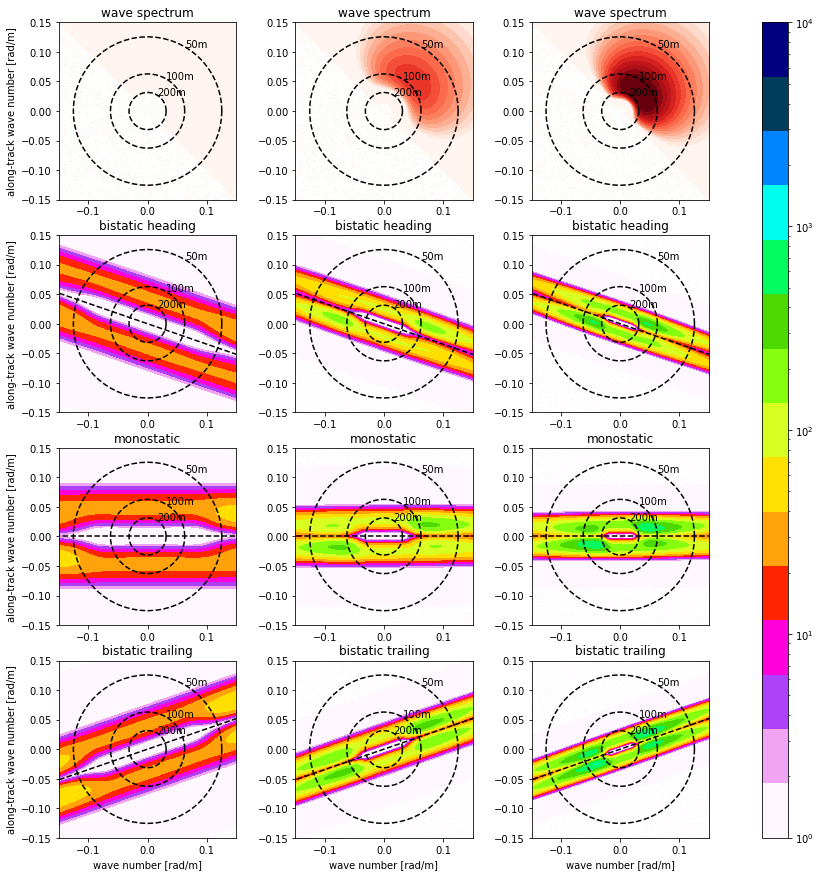

In [4]:
MTF='Kirchhoff'

# wavelength circles
k100=2*np.pi/100;
k200=2*np.pi/200;
k50=2*np.pi/50;
ph=np.linspace(0,2*np.pi,61)
kx50=np.cos(ph)*k50
ky50=np.sin(ph)*k50
kx100=np.cos(ph)*k100
ky100=np.sin(ph)*k100
kx200=np.cos(ph)*k200
ky200=np.sin(ph)*k200

# approximate heading line
kxb=[-np.cos(alpha_rot)*np.max(kx),np.cos(alpha_rot)*np.max(kx)]
kyb=[-np.sin(alpha_rot)*np.max(kx),np.sin(alpha_rot)*np.max(kx)]


fig=plt.figure(figsize=(12,15))
plt_lim=0.15

###### let's do this with Elfouhaily
wind_U=np.arange(6,15,4) # wind speed
wind_fetch=500E3 # fetch
wind_dir=45 # wind direction

# go through wind speed
for l in range(0,len(wind_U)):
    # wave-number spectrum
    Sp=elfouhaily(k,wind_U[l],wind_fetch)
    Sp[0,0]=0

    # directional distribution
    dphi = (np.deg2rad(wind_dir)-phi+np.pi) % (2 * np.pi) - np.pi # including unwrapping
    D=elfouhaily_spread(k, dphi, wind_U[l], wind_fetch)
    D[0,0]=0

    # two dimensional spectrum
    S=Sp*D/k
    S[0,0]=0

    # scaling for input into fft (2*pi-scaling inside of the correlation functions)
    S=S*dk*dk*Nx*Ny
    wn_grid={"S": S,"k_x": kx,"k_y": ky}


    # get cross-correlations
    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_m, np.radians(0.0001), mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_m, np.radians(0.0001), Rt, Rt )    
    ord_max=5
    Pm = np.zeros( kx.shape, dtype = complex )
    for m in range( 0, ord_max ):
        xfac = (kx ** 2) ** m / math.factorial( m )
        for n in range( 0, ord_max ):
            yfac = (ky ** 2) ** n / math.factorial( n )
            for o in range( 0, ord_max ):
                xy_fac = (ky * kx) ** o / math.factorial( o )

                if o + n + m < ord_max:
                    dS = xfac * yfac * xy_fac * np.fft.fft2(
                        xx ** m * yy ** n * (yx + xy) ** o * (1 + II) )
                    Pm = Pm + dS

    Pm = np.exp( - kx ** 2 * xx[ 0, 0 ] - ky ** 2 * yy[ 0, 0 ] - ky * kx * (
            yx[ 0, 0 ] + xy[ 0, 0 ] ) ) * Pm * dx * dy
    Pm[0,0]=0

    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, bist_ang, Rt, Rr )
    Pf = np.zeros( kx.shape, dtype = complex )
    for m in range( 0, ord_max ):
        xfac = (kx ** 2) ** m / math.factorial( m )
        for n in range( 0, ord_max ):
            yfac = (ky ** 2) ** n / math.factorial( n )
            for o in range( 0, ord_max ):
                xy_fac = (ky * kx) ** o / math.factorial( o )

                if o + n + m < ord_max:
                    dS = xfac * yfac * xy_fac * np.fft.fft2(
                        xx ** m * yy ** n * (yx + xy) ** o * (1 + II) )
                    Pf = Pf + dS

    Pf = np.exp( - kx ** 2 * xx[ 0, 0 ] - ky ** 2 * yy[ 0, 0 ] - ky * kx * (
            yx[ 0, 0 ] + xy[ 0, 0 ] ) ) * Pf * dx * dy
    Pf[0,0]=0

    T_I = SAR_model.transfer_func_RAR_bist( kx, ky, inc_m, inc_b, bist_ang, mtf = MTF )
    II, yy, xx, Iy, yI, Ix, xI, xy, yx = SAR_model.corr_func_bist( wn_grid, T_I, inc_m, inc_b, -bist_ang, Rt, Rr )
    Pb = np.zeros( kx.shape, dtype = complex )
    for m in range( 0, ord_max ):
        xfac = (kx ** 2) ** m / math.factorial( m )
        for n in range( 0, ord_max ):
            yfac = (ky ** 2) ** n / math.factorial( n )
            for o in range( 0, ord_max ):
                xy_fac = (ky * kx) ** o / math.factorial( o )

                if o + n + m < ord_max:
                    dS = xfac * yfac * xy_fac * np.fft.fft2(
                        xx ** m * yy ** n * (yx + xy) ** o * (1 + II) )
                    Pb = Pb + dS

    Pb = np.exp( - kx ** 2 * xx[ 0, 0 ] - ky ** 2 * yy[ 0, 0 ] - ky * kx * (
            yx[ 0, 0 ] + xy[ 0, 0 ] ) ) * Pb * dx * dy
    Pb[0,0]=0
    
    plt.subplot(4,3,l+1)
    cmap2=cm.get_cmap('Reds', 15)
    img2=plt.imshow(np.fft.fftshift(S/(dk*dk*Nx*Ny)),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap=cmap2, origin='lower',norm=LogNorm(vmin=1, vmax=1E2))
    plt.title('wave spectrum')
    if l == 0:
        plt.ylabel('along-track wave number [rad/m]')
    plt.plot(kx50,ky50,'k--')
    plt.plot(kx100,ky100,'k--')
    plt.plot(kx200,ky200,'k--')
    plt.text(kx50[10],ky50[10],'50m',color='k')
    plt.text(kx100[10],ky100[10],'100m',color='k')
    plt.text(kx200[10],ky200[10],'200m',color='k')
    plt.xlim(-plt_lim,plt_lim)
    plt.ylim(-plt_lim,plt_lim)
    
    vmi=1E0
    vma=1E4#np.max(np.absolute(Pm))
    # bi-static case (forward)
    plt.subplot(4,3,l+4)
    cmap=cm.get_cmap('gist_ncar_r', 15)
    plt.imshow(np.fft.fftshift(np.absolute(Pf)),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap=cmap, origin='lower',norm=LogNorm(vmin=vmi, vmax=vma))
    plt.title('bistatic heading')
    if l == 0:
        plt.ylabel('along-track wave number [rad/m]')
    plt.plot(kx50,ky50,'k--')
    plt.plot(kx100,ky100,'k--')
    plt.plot(kx200,ky200,'k--')
    plt.plot(kxb,np.flip(kyb),'k--')
    plt.text(kx50[10],ky50[10],'50m',color='k')
    plt.text(kx100[10],ky100[10],'100m',color='k')
    plt.text(kx200[10],ky200[10],'200m',color='k')
    plt.xlim(-plt_lim,plt_lim)
    plt.ylim(-plt_lim,plt_lim)

    # mono-static case
    #P=P3/np.max(P3)
    plt.subplot(4,3,l+7)
    img=plt.imshow(np.fft.fftshift(np.absolute(Pm)),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap=cmap, origin='lower',norm=LogNorm(vmin=vmi, vmax=vma))
    plt.title('monostatic')
    if l == 0:
        plt.ylabel('along-track wave number [rad/m]')
    plt.plot(kx50,ky50,'k--')
    plt.plot(kx100,ky100,'k--')
    plt.plot(kx200,ky200,'k--')
    plt.plot(kxb,[0,0],'k--')
    plt.text(kx50[10],ky50[10],'50m',color='k')
    plt.text(kx100[10],ky100[10],'100m',color='k')
    plt.text(kx200[10],ky200[10],'200m',color='k')
    plt.xlim(-plt_lim,plt_lim)
    plt.ylim(-plt_lim,plt_lim)
    
    # bi-static case (backward)
    #P=P2/np.max(P2)
    plt.subplot(4,3,l+10)
    plt.imshow(np.fft.fftshift(np.absolute(Pb)),extent=(np.min(kx),np.max(kx),np.min(ky),np.max(ky)),cmap=cmap, origin='lower',norm=LogNorm(vmin=vmi, vmax=vma))
    plt.title('bistatic trailing')
    if l == 0:
        plt.ylabel('along-track wave number [rad/m]')
    plt.plot(kx50,ky50,'k--')
    plt.plot(kx100,ky100,'k--')
    plt.plot(kx200,ky200,'k--')
    plt.plot(kxb,kyb,'k--')
    plt.text(kx50[10],ky50[10],'50m',color='k')
    plt.text(kx100[10],ky100[10],'100m',color='k')
    plt.text(kx200[10],ky200[10],'200m',color='k')
    plt.xlabel('wave number [rad/m]')
    plt.xlim(-plt_lim,plt_lim)
    plt.ylim(-plt_lim,plt_lim)

# add the colorbars
cbaxes = fig.add_axes([0.95, 0.125, 0.03, 0.755]) 
cb = plt.colorbar(img, cax = cbaxes, orientation='vertical')
#cbaxes = fig.add_axes([0.55, 0.05, 0.345, 0.03]) 
#cb = plt.colorbar(img2, cax = cbaxes, orientation='horizontal')

plt.savefig(outpath + 'uniform_wind.png',dpi=300)